# Определение стоимости автомобилей

## Подготовка данных

In [1]:
#импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
#загрузка данных

df = pd.read_csv('/datasets/autos.csv')

In [3]:
#проверка на явные дубликаты 

df.duplicated().sum()

4

In [4]:
#удаление повторов

df = df.drop_duplicates(keep='first')

In [5]:
#приведение названий столбцов к нижнему регистру

df.columns = df.columns.str.lower()

In [6]:
#удаление неинформативных столбцов, о пользователе

df = df.drop(['datecrawled', 'registrationmonth', 'postalcode', 'lastseen'], axis=1)

In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354365 non-null  int64 
 1   vehicletype       316875 non-null  object
 2   registrationyear  354365 non-null  int64 
 3   gearbox           334532 non-null  object
 4   power             354365 non-null  int64 
 5   model             334660 non-null  object
 6   kilometer         354365 non-null  int64 
 7   fueltype          321470 non-null  object
 8   brand             354365 non-null  object
 9   repaired          283211 non-null  object
 10  datecreated       354365 non-null  object
 11  numberofpictures  354365 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 35.1+ MB


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,numberofpictures
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,0
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,0


In [8]:
#заполним пропуски в категориальных переменных на "неизвестно"

columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'repaired']

df[columns] = df[columns].fillna('unknown')

In [9]:
df.describe()

,price,registrationyear,power,kilometer,numberofpictures
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.0
mean,4416.679830,2004.234481,110.093816,128211.363989,0.0
std,4514.176349,90.228466,189.851330,37905.083858,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


In [10]:
#удаление столбца numberofpictures - он не содержит данных, причина скорее всего техническая

df = df.drop(['numberofpictures'], axis=1)

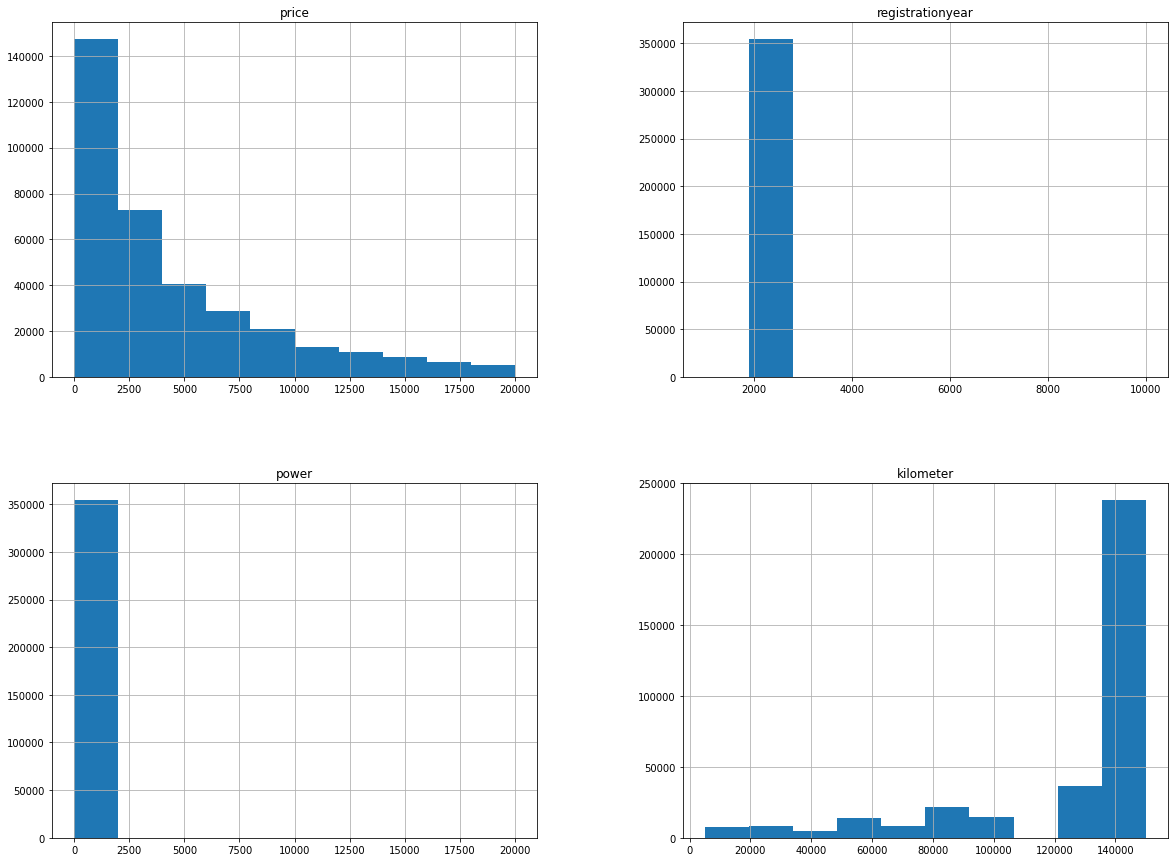

In [11]:
df.hist(figsize=(20, 15));

По гистограммам количественных параметров видны аномалии в power и registrationyear

In [12]:
#удаление аномалий в price

df = df[df['price']>2]

In [13]:
#удаление аномалий в registrationyear

df = df[(df['registrationyear']>1900) & (df['registrationyear']<2016)]

Можно предложить заказчику доработать сервис, чтобы пользователь мог ввести только данные, соответствующие действительности, чтобы модель работала в последствии корректно.

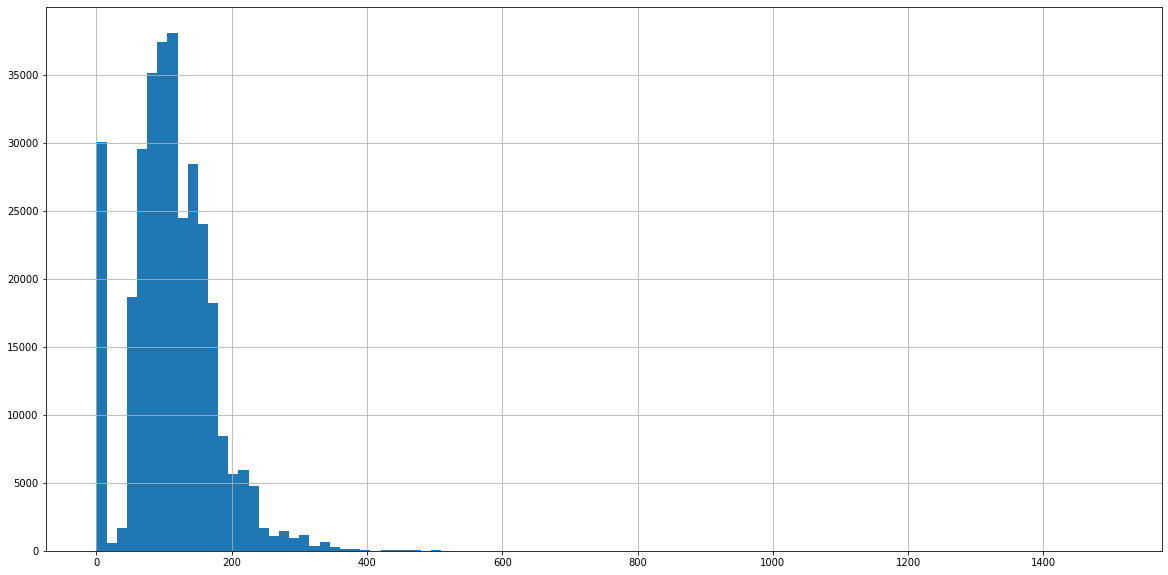

In [14]:
#распределение значений параметра power

df['power'].hist(bins=100, figsize=(20,10), range=(0, 1500));

Неизвестно, откуда существует такое количество машин с 0 л.с. в базе, возможно, так помечались неработающие машины, или пользователи вводили так по ошибке. Проверим, отличается ли цена у машин со значением 0 и не 0 в параметре power

Распределение цен на машины со значением 0 в параметре power


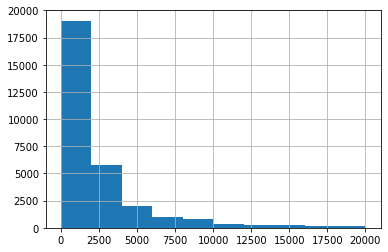

In [15]:
print('Распределение цен на машины со значением 0 в параметре power')
df.loc[df['power'] == 0, 'price'].hist();

Распределение цен на машины


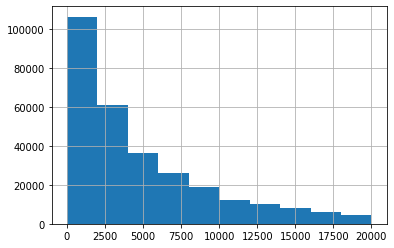

In [16]:
print('Распределение цен на машины')
df.loc[df['power'] != 0, 'price'].hist();

Поскольку машины с аномально низним значением в мощности могут стоить и дешево, и дорого, как и машины с обычной мощностью, нельзя сделать вывод, что 0 - обозначение, например, неработающей машины, и скорее всего это значение по ошибке вводил пользователь - что, как мне кажется, тоже нужно оговорить с заказчиком для совершенствования сервиса. 
Объем аномалий в мощности велик относительно выборки, поэтому их нельзя удалить. Заменим их медианным значением по группе

In [17]:
#замена аномальных значений в power медианой по соответствующей модели

df.loc[(df['power'] < 4)|(df['power'] > 2050), 'power'] = float('nan')
df['power'] = df['power'].fillna(df.groupby(['brand', 'model'])['power'].transform('median'))

#замена оставшихся пропусков, которых не удалось сгруппировать

df['power'] = df['power'].fillna(df['power'].median())

In [18]:
df['power']= df['power'].astype('int64')

In [19]:
#преобразование в формат даты datecreated

df['datecreated'] = pd.to_datetime(df['datecreated'], format='%Y-%m-%dT%H:%M:%S') 

In [20]:
#выделение характеристик из даты

df['year'] = df['datecreated'].dt.year
df['month'] = df['datecreated'].dt.month
df['weekday'] = df['datecreated'].dt.weekday

In [21]:
#удаление столбца datecreated 

df = df.drop(['datecreated'], axis=1)

In [22]:
#выделение целевого признака

target = df['price']
features = df.drop('price', axis=1)

In [23]:
#деление на тренировочную, валидационную и тестовую выборки

#выделение тренировочной части в соотношении 60% и 40%
fea_train, fea_other, tar_train, tar_other = train_test_split(features, target, test_size=0.4, random_state=12345)

#деление оставшейся части на валидационную и тестовую выборки пополам
fea_val, fea_test, tar_val, tar_test = train_test_split(fea_other, tar_other, test_size=0.5, random_state=12345)

print(fea_train.shape)
print(fea_val.shape)
print(fea_test.shape)
print(tar_train.shape)
print(tar_val.shape)
print(tar_test.shape)

(191833, 12)
(63945, 12)
(63945, 12)
(191833,)
(63945,)
(63945,)


In [24]:
# прямое кодирование (для линейных моделей)

encoder = OneHotEncoder(handle_unknown='ignore')
fea_train_ohe = encoder. fit_transform(fea_train)
fea_val_ohe = encoder. transform(fea_val)
fea_test_ohe = encoder. transform(fea_test)

In [25]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['vehicletype', 'registrationyear', 'gearbox', 'model', 'fueltype', 'brand', 'repaired', 'year', 'month', 'weekday']
encoder.fit(fea_train[cat_columns])

fea_train_ord = fea_train.copy()
fea_val_ord = fea_val.copy()
fea_test_ord = fea_test.copy()

fea_train_ord[cat_columns] = encoder.transform(fea_train_ord[cat_columns])
fea_val_ord[cat_columns] = encoder.transform(fea_val_ord[cat_columns])
fea_test_ord[cat_columns] = encoder.transform(fea_test_ord[cat_columns])

## Обучение моделей

In [26]:
%%time

#обучение модели линейной регрессии

model1 = LinearRegression()
model1.fit(fea_train_ohe, tar_train)

CPU times: user 19.8 s, sys: 36.9 s, total: 56.7 s
Wall time: 56.9 s


LinearRegression()

In [27]:
%%time

#получение предсказаний от модели линейной регрессии
predicted_val1 = model1.predict(fea_val_ohe)

CPU times: user 1.65 ms, sys: 8.97 ms, total: 10.6 ms
Wall time: 4.69 ms


In [28]:
result_lr = mean_squared_error(tar_val, predicted_val1) ** 0.5
print("RMSE модели линейной регресси на валидационной выборке:", result_lr)

RMSE модели линейной регресси на валидационной выборке: 2012.6071344327859


In [29]:
#подбор параметров для модели дерева решений

best_depth = 0
result_dtr = 99999
for depth in range(2, 100, 10):
    model2 = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model2.fit(fea_train_ord, tar_train)
    predicted_val2 = model2.predict(fea_val_ord)
    result = mean_squared_error(tar_val, predicted_val2) ** 0.5
    if result < result_dtr:
        best_depth = depth
        result_dtr = result
print("max_depth =", best_depth)
print("RMSE модели дерева решений на валидационной выборке:", result_dtr) 

max_depth = 12
RMSE модели дерева решений на валидационной выборке: 1922.1984282224337


In [30]:
%%time
#измерение времени обучения модели дерева решений с подобранной глубиной

model2 = DecisionTreeRegressor(max_depth=12, random_state=12345)
model2.fit(fea_train_ord, tar_train)

CPU times: user 541 ms, sys: 0 ns, total: 541 ms
Wall time: 547 ms


DecisionTreeRegressor(max_depth=12, random_state=12345)

In [31]:
%%time
#измерение времени предсказания модели дерева решений

predicted_val2 = model2.predict(fea_val_ord)

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 12.6 ms


In [32]:
#словарь с параметрами для модели LightGBM

rates = [0.01, 0.04, 0.07, 0.1]
parametrs = { 'learning_rate': rates,
              'max_depth': range (1, 100, 10),
              'n_estimators': range (1, 100, 10) }

In [33]:
model = lgb.LGBMRegressor()

In [34]:
#подбор параметров модели LGBMRegressor

grid = GridSearchCV(model, parametrs, cv=5, n_jobs=-1)
grid.fit(fea_train_ohe, tar_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.04, 0.07, 0.1],
                         'max_depth': range(1, 100, 10),
                         'n_estimators': range(1, 100, 10)})

In [35]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 31, 'n_estimators': 91}

In [42]:
%%time

#измерение времени обучения модели LGBMRegressor

model = lgb.LGBMRegressor(learning_rate=0.1, max_depth=31, n_estimators=91)
model.fit(fea_train_ohe, tar_train)

CPU times: user 6.29 s, sys: 77.9 ms, total: 6.37 s
Wall time: 6.46 s


LGBMRegressor(max_depth=31, n_estimators=91)

In [43]:
%%time

#измерение времени предсказания LGBMRegressor

predicted_val = model.predict(fea_val_ohe)

CPU times: user 550 ms, sys: 2.83 ms, total: 553 ms
Wall time: 425 ms


In [44]:
resultgbm = mean_squared_error(tar_val, predicted_val) ** 0.5

In [45]:
print('RMSE модели LightGBM на валидационной выборке', resultgbm)

RMSE модели LightGBM на валидационной выборке 1938.9402869961364


## Анализ моделей

На предыдущем этапе было проверено 3 модели - линейная регрессия, дерево решений и LGBMRegressor, обладающие разными характеристиками. 
Критерии, которые важны заказчику:
1. качество предсказания;
2. время обучения модели;
3. время предсказания модели.

In [46]:
data = pd.DataFrame({'model': ['LinearRegression', 'DecisionTree', 'LightGBM'], 'rmse': [result_lr, result_dtr, resultgbm], 'время обучения': ['46.7 s', '449 ms', '47.7 s'], 'время предсказания': ['2.32 ms', '11.3 ms', '497 ms']})
data

,model,rmse,время обучения,время предсказания
0,LinearRegression,2012.607134,46.7 s,2.32 ms
1,DecisionTree,1922.198428,449 ms,11.3 ms
2,LightGBM,1938.940287,47.7 s,497 ms


Модель DecisionTree(max_depth=12) показывает лучшее качество и скорость обучения, по времени предсказания уступает Линейной регрессии почти в 4 раза, которая так же подходит под критерий качества, но обучается относительно долго. Исходя из критериев заказчика, лучше подходит модель DecisionTree

## Тестирование лучшей модели

In [47]:
#тестирование дерева решений 

predicted_test = model2.predict(fea_test_ord)
print('RMSE лучшей модели на тестовой выборке', mean_squared_error(tar_test, predicted_test) ** 0.5)

RMSE лучшей модели на тестовой выборке 1908.722651053233
